In [ ]:
! pip install tensorflow=2.19.0 matplotlib=3.10.1 scipy=1.15.2

Import Libraries

In [1]:
# deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras import layers

import os
from PIL import Image
import shutil

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Load CIFAR-10 dataset for training images
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Convert numpy arrays from CIFAR-10 dataset to .pngs for data loader. 
- Create a directory to save all the images to and name each .png file
- Create a list for the class labels
- Define a second train directory for the training data set
- Create a folder for each class label within the train directory and sort each image by its respective class
- flatten the y_train dataset to map the images to their respective labels

In [4]:
# Define the save directory
save_dir = "images/raw"
os.makedirs(save_dir, exist_ok=True)  # 2nd arg creates the folder if it doesn't exist

# Save images
for i, img_array in enumerate(x_train):
    img = Image.fromarray(img_array)
    img.save(os.path.join(save_dir, f"{i}.png"))

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Output folder for organized images
output_folder = 'images/train'

# Create folders based on each class label
for class_name in class_names:
    os.makedirs(os.path.join(output_folder, class_name), exist_ok=True)

# Sort images into folders based on labels
for i, label in enumerate(y_train.flatten()):
    class_name = class_names[label]
    source_path = os.path.join(save_dir, f'{i}.png')  # Assuming files are named sequentially
    output_path = os.path.join(output_folder, class_name, f'{i}.png')
    if os.path.exists(source_path):  # Ensure the file exists before moving
        shutil.move(source_path, output_path)

KeyboardInterrupt: 

In [5]:
# create parameters for data loader
batch_size = 32
img_height = 224
img_width = 224
train_dir = 'images/train'
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.


In [6]:
# create a validation data loader
valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

Found 50000 files belonging to 10 classes.
Using 10000 files for validation.


In [7]:
# verify class names
class_names = train_set.class_names
print(class_names)
print(len(class_names))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


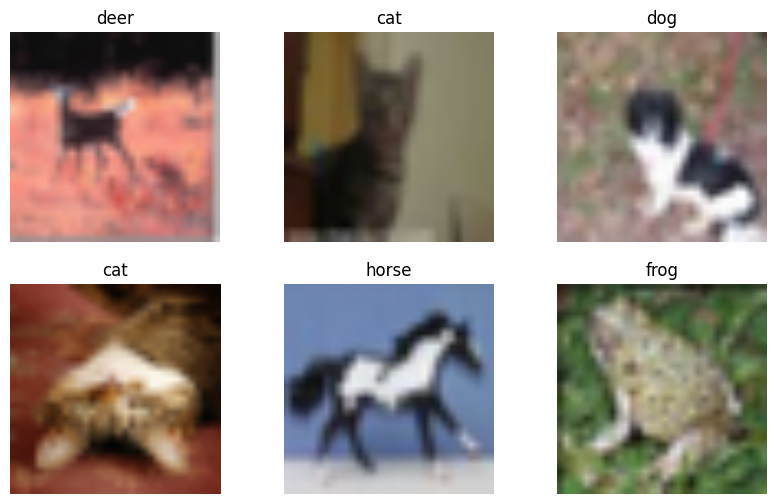

In [8]:
# see sample images within the training dataset
plt.figure(figsize=(10,6))
for images, labels in train_set.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor with the shape (32,224,224,3). There are 32 images in this batch with a shape of 224x224x3 where the third dimension represents the RGB kernel.
The `label_batch` is a tensor with the shape (32,) where there are 32 labels corresponding the images within the batch.

In [9]:
# find the shape of the data
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


Standardization Layer
- normalize the pixel values in the training dataset
- pixel values fall between 0 and 1

In [10]:
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

Data Augmentation Layer
- apply random flip and random rotation

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

Reduce idle time between batches/bottlenecking 

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

Model Training
- Use a Sequential model of three convolution block each accompanied by a max pooling layer.
- Activate a fully-connected Dense layer with the ReLU activation function
- Output layers contains classes

In [13]:
# create the model
num_classes = len(class_names)

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

c:\Users\Cameron\Desktop\Google Coursera\Deep Learning with Tensorflow and Keras\Module 2 - Advanced CNNs in Keras\Advanced Data Augmentation Lab\ad_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# train the model
epochs=30
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=epochs
)

Epoch 1/30


c:\Users\Cameron\Desktop\Google Coursera\Deep Learning with Tensorflow and Keras\Module 2 - Advanced CNNs in Keras\Advanced Data Augmentation Lab\ad_venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 234ms/step - accuracy: 0.2733 - loss: 1.9853 - val_accuracy: 0.4112 - val_loss: 1.6336
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 613s 459ms/step - accuracy: 0.4070 - loss: 1.6445 - val_accuracy: 0.4418 - val_loss: 1.5432
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 305s 244ms/step - accuracy: 0.4352 - loss: 1.5662 - val_accuracy: 0.4584 - val_loss: 1.5067
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 340s 272ms/step - accuracy: 0.4506 - loss: 1.5219 - val_accuracy: 0.4769 - val_loss: 1.4544
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 325s 260ms/step - accuracy: 0.4595 - loss: 1.4926 - val_accuracy: 0.4928 - val_loss: 1.4120
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 336s 269ms/step - accuracy: 0.4765 - loss: 1.4617 - val_accuracy: 0.4855 - val_loss: 1.4316
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 309s 247ms/step - accuracy: 0.4843 - loss: 1.4368 - val_accuracy: 0.4939 - val_loss: 1.3976
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 382s 306ms/step - accuracy: 0.4

Training Results

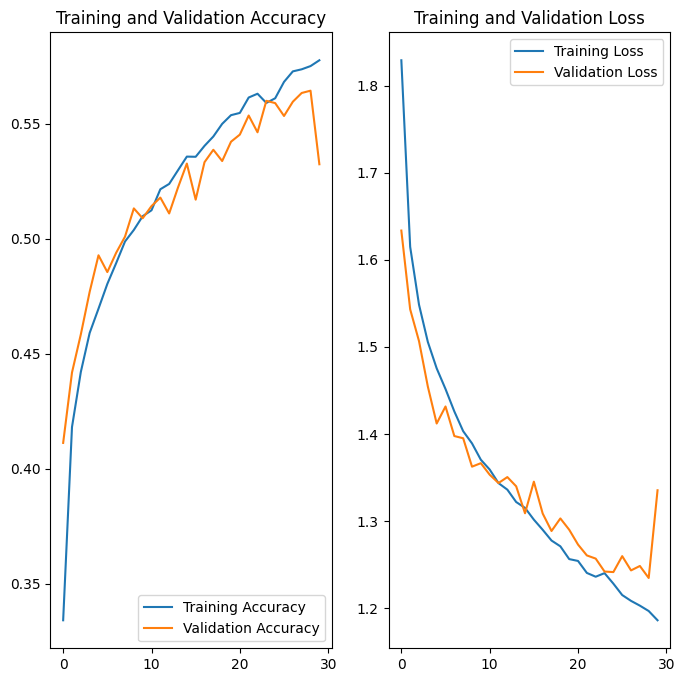

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the model for reuse without training

In [18]:
model.save('model.h5')

In [19]:
new_model = tf.keras.models.load_model('model.h5')

Make a Prediction

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


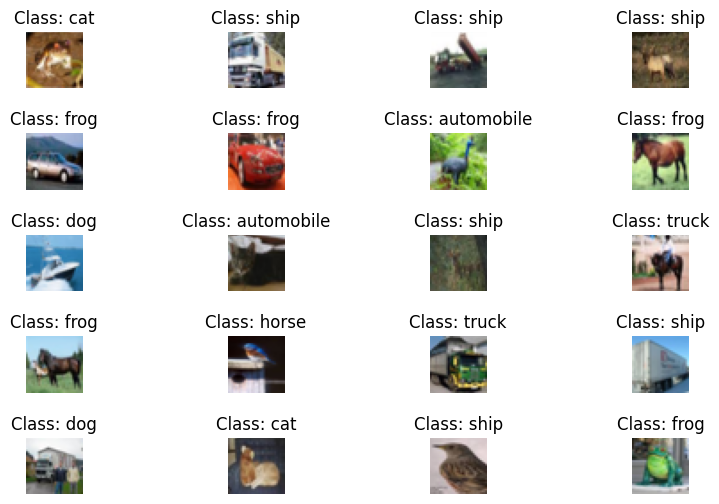

In [20]:
y_pred = new_model.predict(x_test)

n = 20
plt.figure(figsize=(10,6))
for i in range(n):
    predicted_class_idx = np.argmax(y_pred[i])
    predicted_class = class_names[predicted_class_idx]
    plt.subplot(5,4,i+1)
    plt.subplots_adjust(hspace=0.8)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title(f'Class: {predicted_class}')
plt.show()